# Image Classification with CNN using Keras

# Task 1: Import Libraries

In [3]:
import tensorflow as tf
import os
import numpy as np

from matplotlib import pyplot as plt
%matplotlib inline

if not os.path.isdir('models'):
    os.mkdir('models')

tf.config.list_physical_devices('GPU')   
print('TensorFlow version:', tf.__version__)
print('Is using GPU?', tf.test.is_gpu_available())

TensorFlow version: 2.2.0
Is using GPU? False


# Task 2: Preprocess Data

In [4]:
#CIFAR-10 is a well-understood dataset and widely used for benchmarking computer vision algorithms in the field of machine learning.
#We can see that there are 50,000 examples in the training dataset and 
#10,000 in the test dataset and that images are indeed square with 32×32 pixels and color, with three channels.
#we will create a subset it wil have 3 classes instead of 10, and will have 15000 examples only.
def get_three_classes(x, y):
    indices_0, _ = np.where(y == 0.)
    indices_1, _ = np.where(y == 1.)
    indices_2, _ = np.where(y == 2.)

    indices = np.concatenate([indices_0, indices_1, indices_2], axis=0)
    
    x = x[indices]  #we will select items and labels which correspond to those indices.
    y = y[indices]
    
    count = x.shape[0]  #count is the number of examples that we have selected after the concatenation, replace will prevent repetition
    indices = np.random.choice(range(count), count, replace=False)  #we will suffle those indices by using random function
    
    x = x[indices]  #we are shuffeling the places of our examples
    y = y[indices]
    
    y = tf.keras.utils.to_categorical(y)
    
    return x, y

In [5]:
(x_train, y_train),(x_test, y_test)=tf.keras.datasets.cifar10.load_data()
x_train, y_train=get_three_classes(x_train, y_train)
x_test, y_test=get_three_classes(x_test, y_test)

print(x_train.shape, y_train.shape) #train set now has 15k ex in the training set, 32*32 is the size, 3 is the channel
print(x_test.shape, y_test.shape)  #test set now has 3k ex in the test set

170500096/170498071 [==============================] - 3s 0us/step
(15000, 32, 32, 3) (15000, 3)
(3000, 32, 32, 3) (3000, 3)


# Task 3: Visualize Examples

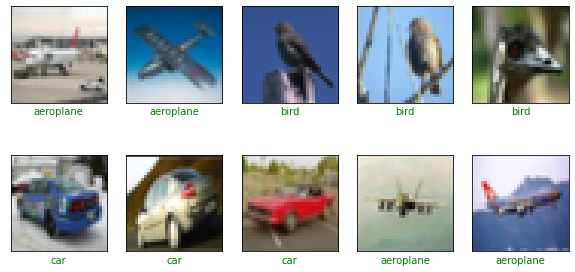

In [6]:
class_names = ['aeroplane', 'car', 'bird'] #3 class names with 0,1 and 2 respectively

def show_random_examples(x,y,p): #x,y are the example labels and p is prediction
  indices=np.random.choice(range(x.shape[0]),10,replace=False)

  x=x[indices]
  y=y[indices]
  p=p[indices]

  plt.figure(figsize=(10, 5))
  for i in range(10):
    plt.subplot(2,5,1+i) #2 rows, 5 columns and index starting with 1
    plt.imshow(x[i])
    plt.xticks([]) #don't show ticks
    plt.yticks([]) #don't show ticks
    #if the label is same as the prediction then will write in green else in red
    col='green' if np.argmax(y[i])==np.argmax(p[i]) else 'red'
    plt.xlabel(class_names[np.argmax(p[i])], color=col)
  plt.show()

show_random_examples(x_train, y_train, y_train)  





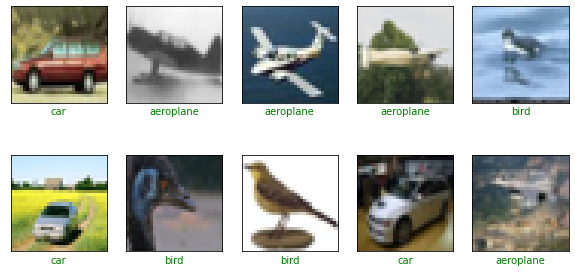

In [7]:
show_random_examples(x_test, y_test, y_test)

# Task 4: Create Model

In [9]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.layers import Dropout, Flatten, Input, Dense

def create_model():
  def add_conv_block(model, num_filters):
    model.add(Conv2D(num_filters, 3, activation='relu', padding='same'))  #3 is kernel size
    model.add(BatchNormalization())
    model.add(Conv2D(num_filters, 3, activation='relu'))  #another convolutional layer without padding will help not to keep row and column same during inputs
    model.add(MaxPooling2D(pool_size=2)) #wil reduce the rows and columns to half the original value
    model.add(Dropout(0.5))
    return model

  model=tf.keras.models.Sequential()
  model.add(Input(shape=(32, 32, 3)))

  #now we wil add convolutional blocks
  model=add_conv_block(model, 32)  #first with 32 filters
  model=add_conv_block(model, 64)
  model=add_conv_block(model, 128)

  #then the output of the final convolutional block
  model.add(Flatten())
  model.add(Dense(3, activation='softmax'))  #Dense layer with 3 nodes 


  #ultimately we need the distribution among the three classes that we have
  model.compile(
      loss='categorical_crossentropy',
      optimizer='adam', metrics=['accuracy']
  )
  return model  #model is compiled now we'll return it

model=create_model()
model.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization_3 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 30, 30, 32)        9248      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 15, 15, 64)        18496     
_________________________________________________________________
batch_normalization_4 (Batch (None, 15, 15, 64)       

# Task 5: Train the Model

In [15]:
h=model.fit(
    x_train/255., y_train/255.,
    validation_data=(x_test/255.,y_test),  #we want features to range between -1 to 2 thus dividing will give that as 255 is the final value of pixels 
    epochs=10, batch_size=98,
    callbacks=[        #callbacks when if our training is not going in the right direction we can make the changes
          tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3),  #this means if the validation does not increases for 3 epochs we can stop the training        
          tf.keras.callbacks.ModelCheckpoint(
              r'C:\Users\ASUS\My projects\Image classification with CNN using keras\models/model_{val_accuracy:.3f}.h5',
              save_best_only=True, save_weights_only=False,   #we don't want to save all the models from all the epochs just the models that perform  better than the previous one
              monitor='val_accuracy' 
      )
   ]
)

Epoch 1/10
154/154 [==============================] - 83s 541ms/step - loss: 109.5458 - accuracy: 0.3343 - val_loss: 3471.8000 - val_accuracy: 0.3333
Epoch 2/10
154/154 [==============================] - 84s 545ms/step - loss: 126.8758 - accuracy: 0.3315 - val_loss: 2529.4839 - val_accuracy: 0.3333
Epoch 3/10
154/154 [==============================] - 84s 545ms/step - loss: 145.7098 - accuracy: 0.3372 - val_loss: 6688.5093 - val_accuracy: 0.3333
Epoch 4/10
154/154 [==============================] - 83s 541ms/step - loss: 168.2171 - accuracy: 0.3217 - val_loss: 4052.8914 - val_accuracy: 0.3290


# Task 6: Final Predictions

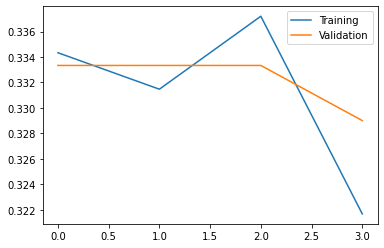

In [16]:
accs=h.history['accuracy']
val_accs=h.history['val_accuracy']

plt.plot(range(len(accs)), accs, label='Training')
plt.plot(range(len(accs)), val_accs, label='Validation')
plt.legend()
plt.show()

In [17]:
model=tf.keras.models.load_model('models/model')

In [ ]:
preds=model.predict(x_test/255.)

In [ ]:
show_random_examples(x_test, y_test, preds)